클러스터링 기법은 다양하게 응용할 수 있다. 예를 들어 신용카드 사기 탐지에서 클러스터링은 사기 거래들을 함께 그룹화해 정상 거래들과 구분할 수 있다. 또는 데이터셋에 레이블이 별로 없는 경우, 클러스터링을 사용해 관측치를 우선 그룹화할 수 있다.(레이블을 사용하지 않음.) 그런 다음 레이블이 지정된 관측치들의 레이블을 동일 그룹 내 나머지 관측치로 전이할 수 있다. 이는 전이 학습의 한 유형이며, 머신러닝에서 빠르게 성장하는 분야이다.

온라인 및 소매 쇼핑, 마케팅, 소셜 미디어 ,영화 , 음악, 책, 데이트 추천 시스템 등과 같은 분야에서 클러스터링은 사용자의 행동을 기반으로 유사한 사람들을 함께 그룹화할 수 있다.이렇게 그룹이 만들어지면 비즈니스 업무 담당자는 그들의 사용자 집단에 대해 더 나은 통찰력을 얻을 수 있으며 각 그룹에 맞는 목표와 비즈니스 전략을 수립할 수 있다.




In [2]:
# pip install fastcluster

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\python.exe -m pip install --upgrade pip' command.


In [4]:
import fastcluster

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: numpy.core.multiarray failed to import

# 5.1 MNIST 데이터셋



## 5.1.1 데이터 준비하기


In [1]:
# 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''알고리즘 관련 라이브러리'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [2]:
# 데이터 셋 로드
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

# 5.2 클러스터링 알고리즘

 클러스터링을 수행하기 전에 PCA를 사용해 데이터의 차원을 줄인다. 3장에서 볼 수 잇듯 차원 축소 알고리즘은 데이터셋의 크기를 줄이면서 원본 데이터의 핵심 정보를 추출. 고차원에서 저차원으로 이동하면서 데이터셋의 노이즈를 최소화한다. 차원 축소 알고리즘( 이 경우 PCA)은 원본 데이터의 가장 중요한 정보를 추출해야 하므로 자주 발생하지 않는 요소(데이터셋의 노이즈와 같은)에 집중할 수 없기 때문이다. 차원축소 알고리즘은 데이터의 내재적 구조를 학습하는 데 매우 강력하다.

In [3]:
# 데이터 셋으로부터 판다스 데이터 프레임 만들기
train_index = range(0,len(X_train))
validation_index = range(len(X_train), \
                         len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation), \
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [4]:
# 주성분 분석(PCA)
from sklearn.decomposition import PCA
n_components = 784 
whiten = False
random_state =2018

pca =PCA(n_components = n_components , whiten = whiten , random_state = random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data =X_train_PCA ,index =train_index)

#### K-means, 계층적 클러스터링, 노이즈 응용 밀도 기반 공간 클러스터링(DBSCAN)을 실행해보자.

# 5.3 K-Means

클러스터링의 목적은 그룹 내 관측치는 서로 유사하지만 다른 그룹의 관측치와는 다르게 구별되는 그룹을 데이터셋에서 식별하는 것이다. K-means 클러스터링은 우리가 원하는 군집 개수인 k를 설정하면 ,알고리즘은 각 관측치를 정확히 k개 군집 중 하나에 할당한다. 알고리즘은 군집 내 분산(within-cluster variation(관성) 을 최소화해 그룹을 최적화한다. 즉 모든 k개 군집별 군집 내 분산의 합이 가능한 한 작아지도록 한다.

k-means 클러스터링은 실행할 때마다 군집 할당 결과가 약간씩 달라질 수 있다. 클러스터링 시작 단계에서 각 관측치를 k개 군집 중 하나에 랜덤하게 할당하기 때문. K-means는 이렇게 랜덤 초기화함으로써 클러스터링을 빠르게 수행한다. 이 랜덤 초기화 후에 각 관측치와 군집의 중심점 또는 중심 간 유클리드 거리를 최소화하도록 관측치를 다른 군집에 재할당한다. 이 랜덤 초기화는 바로 k-means를 실행할 때마다 군집 할당 결과가 약간씩 달라지는 무작위성의 원천이다. 일반적으로 K-means 알고리즘은 여러 번 실행해서 모든 k개 군집의 군집 내 분산의 총합이 가장 낮도록 제일 잘 분류한 실행 결과를 선택한다.



## 5.3.1 K-means 관성

이제 본격적으로 K-means 알고리즘을 살펴보자. 기본적으로 설정해야 하는 항목은 만들려는 군집의 수 (n_cluster), 초기화 횟수(n_init), 최대 반복 횟수(max_iter) , 수렴 허용 오차(tol)이다. 여기에서 최대 반복 횟수는 관성을 최소화하기 위해 관측치를 재할당하기 위한 최대 알고리즘 반복 실행 횟수를 의미한다.


초기화 횟수 10 , 최대 반복횟수 300 , 허용오차 0.0001은 기본값을 사용한다. 그리고 지금은 PCA(cutoff)의 처음 100개 주성분을 사용한다. 설정한 군집 수가 관성 척도에 어떤 영향을 미치는지 테스트하기 위해 군집 개수를 2에서 20까지 조정하면서 k-means를 실행하고 각 관성을 기록하자.



In [22]:
# K-평균 - 군집 수에 따른 관성
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=range(2,21), \
                              columns=['inertia'])
for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_

C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed 

In [23]:
kMeans_inertia

,inertia
2,2.22954e+06
3,2.10984e+06
4,2.02052e+06
5,1.93802e+06
6,1.87624e+06
7,1.83272e+06
8,1.79433e+06
9,1.7576e+06
10,1.72759e+06
11,1.69805e+06


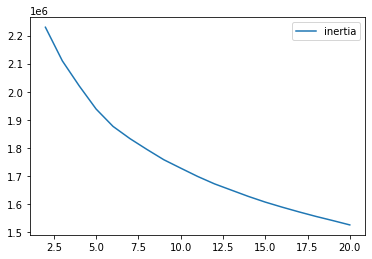

In [26]:
kMeans_inertia.plot()


위 그림을 보면 군집 수가 증가함에 따라 관성이 감소한다. 이는 군집이 많을수록 각 군집 내 관측치 간 동질성이 커진다는 의미이다. 그러나 군집 개수는 적을수록 작업하기가 더 쉬워진다. 따라서 K-means를 실행할 때 적절한 군집 수를 찾는 것이 중요하다.

## 5.3.2 클러스터링 결과 평가하기

k-평균 군집이 어떻게 작동하는지(작동 원리), 어떻게 군집 수가 증가할수록 더욱 동질한 군집이 생성되는지 확인. 이를 위해 각 실험 결과를 분석하는 함수를 정의. 클러스터링 알고리즘이 생성한 군집은 clusterDF라는 판다스 데이터 프레임에 저장된다. 우선 각 군집의 할당된 관측치 개수를 계산해 countByCluster라는 df에 저장.


In [9]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = \
        pd.DataFrame(data=preds.groupby('cluster').agg( \
                        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
                        left_on="cluster",right_on="cluster")
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
                        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
                        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
            accuracyDF, overallAccuracy, accuracyByLabel

####  p195~ 200참조!!

## 5.3.3 K-means 정확도

In [30]:
# K-평균 - 군집 수에 따른 정확도

n_clusters = 5
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = \
    pd.DataFrame(data=[],index=range(2,21),columns=['inertia'])
overallAccuracy_kMeansDF = \
    pd.DataFrame(data=[],index=range(2,21),columns=['overallAccuracy'])

for n_clusters in range(2,21):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = 99
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = \
        pd.DataFrame(data=X_train_kmeansClustered, index=X_train.index, \
                     columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed 

In [31]:
overallAccuracy_kMeansDF

,overallAccuracy
2,0.20832
3,0.2981
4,0.37578
5,0.4515
6,0.47216
7,0.5059
8,0.57418
9,0.57338
10,0.57568
11,0.58892


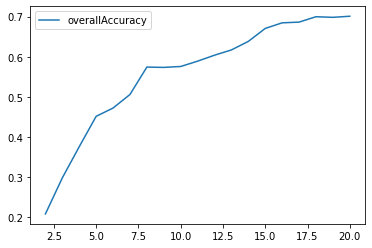

In [32]:
overallAccuracy_kMeansDF.plot()

위 그림을 보면, 클러스터 수가 증가함에 따라 정확도가 향상된다. 즉 ,클러스터 수가 증가함에 따라 각 군집은 더욱 작고 밀접하게 형성되기 때문에 클러스터가 더욱 동질해진다.


군집별 정확도는 상당히 다양하다. 일부 군집은 높은 수준의 동질성을 나타내고 다른 군집은 낮은 수준의 동질성이 보인다. 예를 들어 일부 군집에서는 이미지의 90% 이상이 같은 숫자이며 다른 군집에서는 이미지의 50%미만만 같은 숫자이다.

In [33]:
accuracyByLabel_kMeans

0     0.928138
1     0.848710
2     0.875044
3     0.455337
4     0.592881
5     0.385081
6     0.932831
7     0.721597
8     0.495251
9     0.847551
10    0.891500
11    0.636222
12    0.916833
13    0.956971
14    0.942529
15    0.379933
16    0.464061
17    0.793116
18    0.529367
19    0.949918
dtype: float64

# 5.3.4  K-means와 주성분 개수

클러스터링 알고리즘이 사용하는 주성분 개수에 따라 군집의 동질성(정확도)에 어떤 영향을 미치는지 평가.

이전 실험에서는 일반 PCA에서 파생된 주성분 100개를 사용했다. MNIST 데이터셋의 원본 차원 수는 784개이다. PCA가 데이터의 내재적 구조를 최대한 잘 축약해서 추출하면 클러스터링 알고리즘은 일부 주성분을 사용하든 더 많은 주성분을 사용하든 관계없이 유사한 이미지를 쉽게 그룹화할 수 있다. 즉, 클러스터링은 주성분을 100개 또는 수백 개 사용할 때 처럼 10개 또는 50개 사용해도 잘 수행돼야 한다.

가설. 먼저 클러스터링 알고리즘에 주성분을 10,50,100,200,300,400,500,600,700,784개 적용시킨 후 각 군집 실험의 정확도를 측정. 그런 다음 그 결과를 시각화해 주성분 개수의 변화가 군집 정확도에 어떤 영향을 미치는지 확인.



In [34]:
# K-평균 - 주성분 수에 따른 정확도

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = cutoffNumber
    kmeans.fit(X_train_PCA.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed 

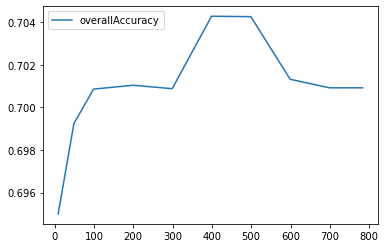

In [35]:
overallAccuracy_kMeansDF.plot()

이 결과는 우리의 가설을 잘 설명해준다. 주성분 개수가 10에서 784까지 다양하게 변하지만 군집 정확도는 안정적이고 일관되게 약 70%를 유지한다. 이것이 바로 차원 축소된 데이터셋에서 클러스터링을 수행해야 하는 이유이다. 

## 일반적으로 클러스터링 알고리즘은 차원 축소된 데이터셋에서는 실행 시간 및 클러스터링 정확도 측면에서 더 잘 수행된다.

MNIST 데이터셋과 같이 원본의 차원 수가 784개 정도라면 클러스터링 알고리즘에서 처리할 수 있다. 하지만 만약 원본 데이터셋이 수천 또는 수백만 차원이라고 상상하면, 이러한 시나리오에서는 클러스터링을 수행하기 전에 차원을 먼저 줄여야한다.



# 5.3.5 원본 데이터셋에서 K-means 실행.

이 점을 명확히 하기 위해 원본 데이터셋에서 클러스터링을 수행하고 알고리즘에서 사용하는 차원의 개수가 클러스터링 정확도에 어떤 영향을 미치는지 측정. 

이전 섹션에서 PCA로 축소된 데이터셋의 경우 클러스터링 알고리즘에서 사용하는 주성분의 개수가 달라져도 군집 정확도는 거의 70%로 안정적이고 일관되게 유지된다. 과연 원본 데이터셋에서도 그럴까?

In [36]:
# K-평균 - 주성분 수에 따른 정확도
# 원본 MNIST 데이터 셋(PCA를 통한 축소가 없는)

n_clusters = 20
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

kMeans_inertia = pd.DataFrame(data=[],index=[9, 49, 99, 199, \
                    299, 399, 499, 599, 699, 783],columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[],index=[9, 49, \
                    99, 199, 299, 399, 499, 599, 699, 783], \
                    columns=['overallAccuracy'])

for cutoffNumber in [9, 49, 99, 199, 299, 399, 499, 599, 699, 783]:
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, \
                max_iter=max_iter, tol=tol, random_state=random_state, \
                n_jobs=n_jobs)

    cutoff = cutoffNumber
    kmeans.fit(X_train.loc[:,0:cutoff])
    kMeans_inertia.loc[cutoff] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train.loc[:,0:cutoff])
    X_train_kmeansClustered = pd.DataFrame(data=X_train_kmeansClustered, \
                                index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, \
        accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans \
        = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[cutoff] = overallAccuracy_kMeans

C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)
C:\Users\admin\AppData\Local\conda\conda\envs\kyu3.7\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWa

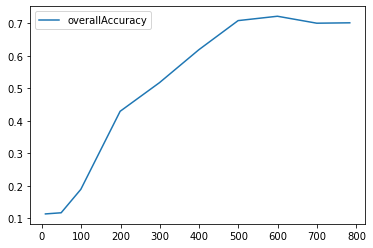

In [37]:
overallAccuracy_kMeansDF.plot()

그림과 같이 군집 정확도는 낮은 차원에서는 매우 좋지 않지만 차원 수가 600개로 증가하면서 거의 70%에 이른다.

PCA의 주성분을 사용했을 때 군집 정확도는 10차원에서도 약 70%였다. 이는 원본 데이터셋에서 핵심 정보를 함축적으로 추출하는 차원 축소의 힘을 입증한 셈이다.

# 5.4 계층적 클러스터링

계층적 클러스터링은 특정한 군집의 개수를 사전에 설정하지 않는다. 대신 계층적 클러스터링 실행이 종료되면 우리가 원하는 군집의 개수를 선택할 수 있다.

계층적 클러스터링 알고리즘은 데이터셋의 관측치를 사용해 덴드로그램을 만든다. 덴드로그램은 트리 잎이 아래쪽에 있고 나무 줄기가 맨 위에 있는 뒤집힌 트리로 나타낼 수 있다. 맨 아래 잎은 데이터셋의 개별 인스턴스이다. 계층적 클러스터링은 서로 얼마나 유사한지에 따라 뒤집힌 트리를 수직 위로 이동하면서 잎을 결합시킨다. 서로 가장 유사한 인스턴스(또는 인스턴스 그룹)는 더욱 빨리 결합하고 유사하지 않은 인스턴스는 나중에 결합한다. 

이러한 과정이 반복되면서 모든 인스턴스는 결국 트리의 단일 줄기를 형성하면서 서로 합쳐진다.

이 수직 그래프는 매우 유용하다. 계층적 클러스터링 알고리즘이 실행되면 덴드로그램을 보고 트리를 잘라낼 위치를 결정할 수 있다 .더 낮은 곳을 잘라낼수록 개별 가지 (즉, 군집)가 더 많이 남는다. 군집 수를 줄이려면 덴드로그램에서 더 높은 곳을 자르면 된다. 군집 수를 줄일수록 뒤집힌 트리의 가장 위에 다일 줄기에 더 가까워진다. 

이러한 수직 절단 위치는 K-means 클러스터링 알고리즘에서 군집 수 k를 선택하는 것과 유사하다.




## 5.4.1 병합 계층적 클러스터링



In [7]:
import fastcluster

from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

cutoff = 99
Z = fastcluster.linkage_vector(X_train_PCA.loc[:,0:cutoff], \
                               method='ward', metric='euclidean')
Z_dataFrame = pd.DataFrame(data=Z, \
    columns=['clusterOne','clusterTwo','distance','newClusterSize'])

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: numpy.core.multiarray failed to import

In [6]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 160
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = \
    pd.DataFrame(data=clusters,index=X_train_PCA.index,columns=['cluster'])

NameError: name 'Z' is not defined

# 5.5 DBSCAN 개요

이제 세 번째이자 마지막 주요 클러스터링 알고리즘인 노이즈 응용 밀도 기반 공간 클러스터링 (density-based spatial clustering of applications with noise, DBSCAN)을 보자. 이름에서 알 수 있듯이, 이 알고리즘은 데이터 포인트의 밀도에 따라 그룹화한다.

DBSCAN은 밀접하게 묵인 포인트를 함께 그룹화한다. 여기서 '밀접하게 묶인'은 특정 거리 내에 존재해야 하는 데이터 포인트의 최소 개수로 정의 된다. 만약 어떤 데이터 포인트가 여러 군집의 특정 거리 내에 있으면 그 포인트는 그중에서 가장 밀도가 높은 군집과 그룹화한다. 그리고 다른 군집의 특정 거리 내에 있지 않는 인스턴스는 모두 이상칠 ㅗ표시한다.

k-means와 계층적 클러스터링에서는 모든 포인트들이 클러스터링되고, 이상치가 제대로 처리되지 않았다. DBSCAN에서는 데이터 포인트에 이상치가 명시적으로 지정되고 클러스터링에서 제외된다. 이는 매우 강력한 기능이다. 이로 인해 DBSCAN은 다른 클러스터링 알고리즘에 비해 데이터의 이상치 때문에 일반적으로 발생하는 왜곡이 훨씬 적다. 또한 K-means와는 달리 계층적 클러스터링 처럼 군집 수를 설정할 필요가 없다.

## 5.5.1 DBSCAN

두 데이터 포인트가 이웃이 되기 위한 조건인 두 포인트 사이의 최대 거리(maximum distance , eps)와 그룹을 군집이라고 부르기 위한 조건인 최소 샘플(minimum samples(min_samples)를 설정해야 한다. eps의 기본값은 0.5이고 min_samples의 기본값은 5이다. eps가 너무 낮게 설정되면 같은 이웃으로 고려할 포인트가 없을 수 있다. 이렇게 되면 모든 포인트가 클러스터링되지 않은 상태로 남아있게 도니다. 반대로 eps가 너무 높게 설정되면 대부분 포인트가 클러스터링돼 소수의 포인트만 클러스터링되지 않은 상태로 남아 데이터셋에 있는 이상치를 효과적으로 분류할 수 있다.

데이터셋에 대한 최적의 eps를 찾아야 한다. 최소 샘플수(min_samples)는 포인트가 군집이 되기 위해 eps거리 내에 포인트가 얼마나 많아야 하는지를 설정한다. 밀접하게 위치한 포인트들이 최소 샘플수 이상 존재하면 소위 중심점(core point)로부터 eps거리 내에 있는 다른 포인트는 해당 군집의 일부가 된다. 다른 포인트가 eps거리 내에 최소 샘플수 만큼 포인트를 갖지 않더라도 말이다.(eps 거리 내에 최소 샘플수 개수의 포인트가 없는) 이러한 다른 포인트를 군집의 경계점(border point)라고 한다.

일반적으로 최소 샘플수가 증가하면 군집 수가 감소해야 한다. 앞서 언급한 eps와 마찬가지로 MNIST 데이터셋에 대한 최적의 최소 샘플수를 찾아야 한다. 
보닷피 군집에는 중심점과 경계점이 있지만 모든 면에서 그들은 동일한 그룹에 속한다. 군집의 중심점 또는 경계점으로 그룹화되지 않는 모든 포인트는 이상치로 레이블된다.

In [10]:
from sklearn.cluster import DBSCAN

eps = 3
min_samples = 5
leaf_size = 30
n_jobs = 4

db = DBSCAN(eps=eps, min_samples=min_samples, leaf_size=leaf_size, 
            n_jobs=n_jobs)

cutoff = 99
X_train_PCA_dbscanClustered = db.fit_predict(X_train_PCA.loc[:,0:cutoff])
X_train_PCA_dbscanClustered = \
    pd.DataFrame(data=X_train_PCA_dbscanClustered, index=X_train.index, \
                 columns=['cluster'])

countByCluster_dbscan, countByLabel_dbscan, countMostFreq_dbscan, \
    accuracyDF_dbscan, overallAccuracy_dbscan, accuracyByLabel_dbscan \
    = analyzeCluster(X_train_PCA_dbscanClustered, y_train)

overallAccuracy_dbscan

0.242

In [11]:
print("Overall accuracy from DBSCAN: ",overallAccuracy_dbscan)

Overall accuracy from DBSCAN:  0.242


In [12]:
print("Cluster results for DBSCAN")
countByCluster_dbscan

Cluster results for DBSCAN


,cluster,clusterCount
0,-1,39575
1,0,8885
2,8,720
3,5,92
4,18,51
...,...,...
95,43,4
96,83,4
97,11,4
98,54,3


군집 결과 표를 살펴보면 대부분의 데이터 포인트가 클러스터링되지 않았다. 훈련셋의 관측치 50,000개 중 39,651개는 cluster 컬럼에서 첫 번째 행인 -에 남아 있으며, 이는 군집에 속하지 않음을 의미한다. 이들은 이상치로 레이블한다. DBSCAN은 뚜렷한 고밀도 포인트 그룹을 찾는데 어려움이 있기 때문에 숫자를 기반으로 하는 MNIST 이미지를 클러스터링하는데 적합하지 않다.

## 5.3.3 HDBSCAN

이 알고리즘은 계층적 노이즈 응용 밀도 기반 공간 클러스터링(HDBSCAN) 또는 계층적 DBSCAN으로 알려져 있으며, 앞서 소개한 DBSCAN 알고리즘을 계층적 클러스터링 알고리즘으로 변환한다. 즉, 밀도를 기반으로 그룹화하고, 앞에서 소개한 계층적 클러스터링 알고리즘처럼 거리를 기준으로 밀도 기반 군집을 반복적으로 연결한다 .


핵심파라미터는 min_cluster_size와 min_samples이다. 만약 min_samples를 None로 설정하면 min_cluster_size로 기본 설정된다. 


In [13]:
import hdbscan

min_cluster_size = 30
min_samples = None
alpha = 1.0
cluster_selection_method = 'eom'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
        min_samples=min_samples, alpha=alpha, \
        cluster_selection_method=cluster_selection_method)

cutoff = 10
X_train_PCA_hdbscanClustered = \
    hdb.fit_predict(X_train_PCA.loc[:,0:cutoff])

X_train_PCA_hdbscanClustered = \
    pd.DataFrame(data=X_train_PCA_hdbscanClustered, \
    index=X_train.index, columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan \
    = analyzeCluster(X_train_PCA_hdbscanClustered, y_train)

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [14]:
import hdbscan

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject